In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM2.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

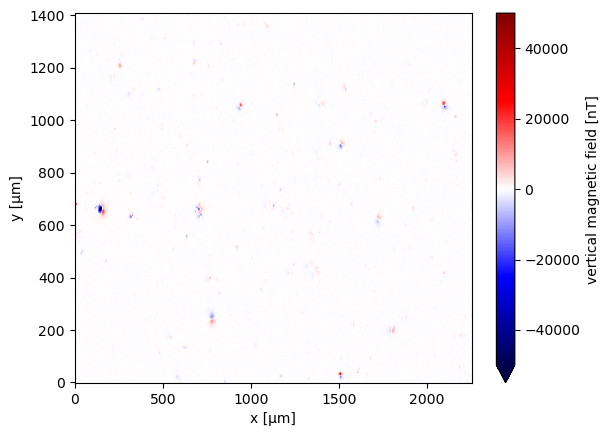

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 52.8 48.71 66.73 83.59 ... 182.6 117.5 76.16

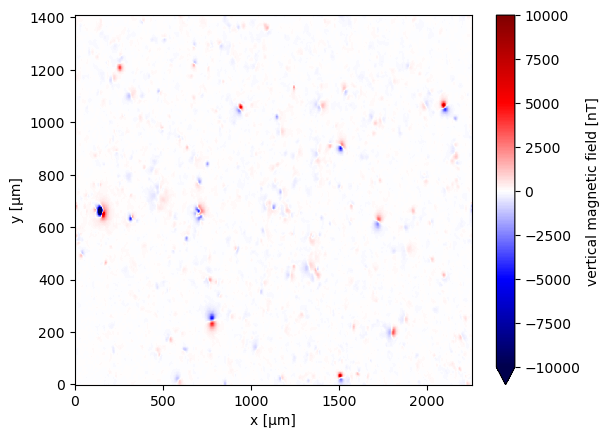

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 52.8 48.71 66.73 83.59 ... 182.6 117.5 76.16
    tga      (y, x) float64 5MB 8.306 12.94 8.112 13.35 ... 35.3 24.31 18.76
    x_deriv  (y, x) float64 5MB -1.742 2.964 7.421 ... -28.87 -22.66 -17.61
    y_deriv  (y, x) float64 5MB -1.673 -0.2701 -1.661 ... 12.36 8.388 3.543
    z_deriv  (y, x) float64 5MB 7.947 12.59 -2.824 -12.35 ... -16.12 2.708 5.416

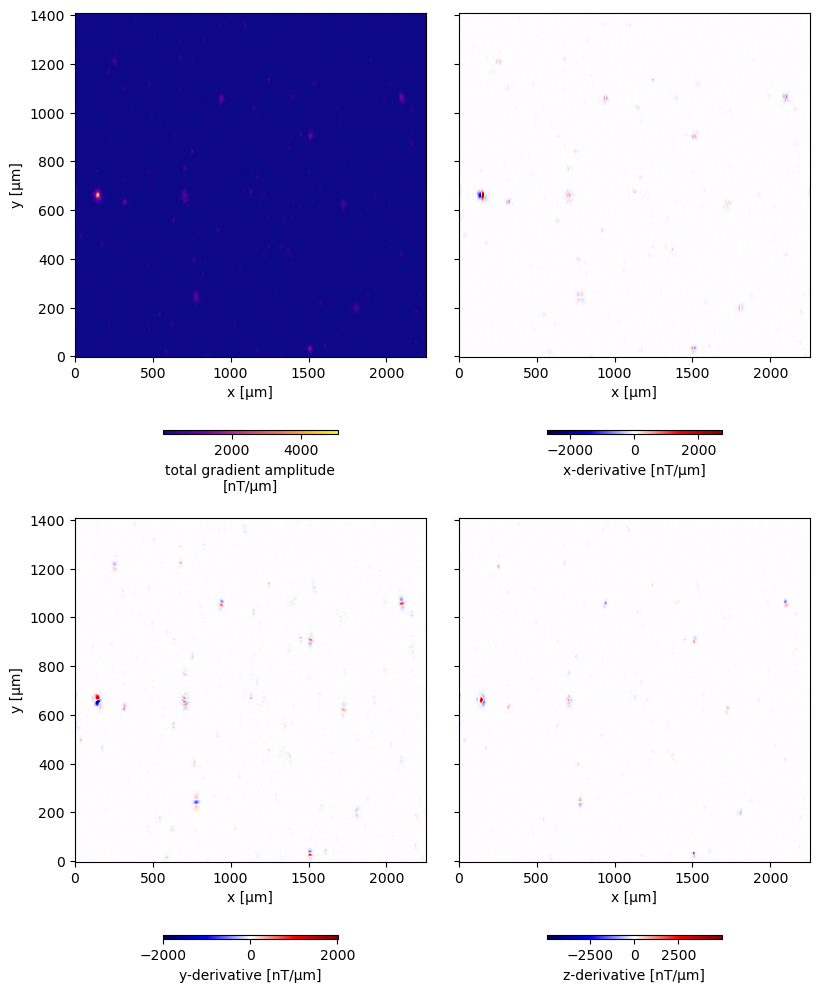

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

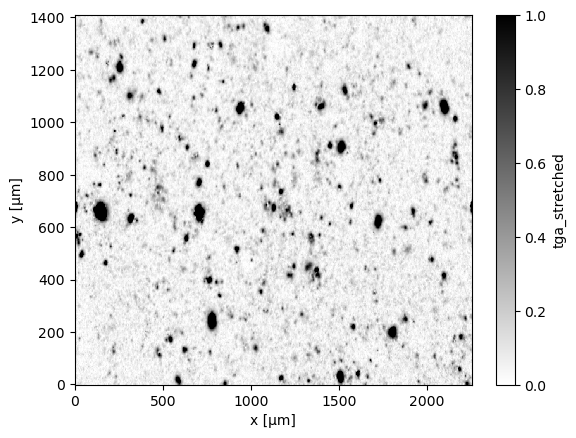

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.05,
    overlap=1.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

658 potential sources detected within 1.7859 seconds


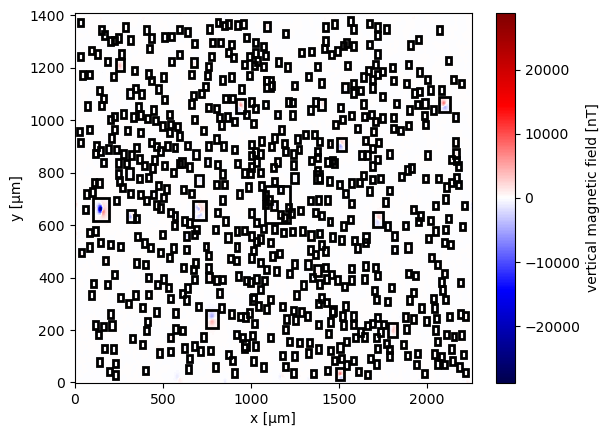

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

658 euler positions and dipole moments estimated within 2.8671 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 152.8248 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z          bz    z_deriv
0  105.75  615.7  10.0  179.388112  -3.956190
1  108.10  615.7  10.0  191.142186   0.596119
2  110.45  615.7  10.0  215.220053  -4.392949
3  112.80  615.7  10.0  242.257243 -16.146605
4  115.15  615.7  10.0  254.553316 -16.972992

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

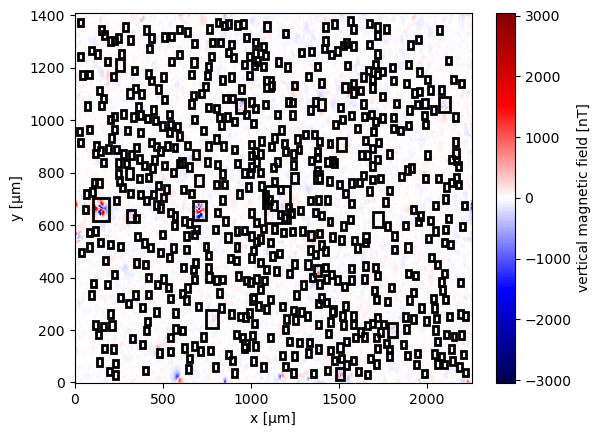

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

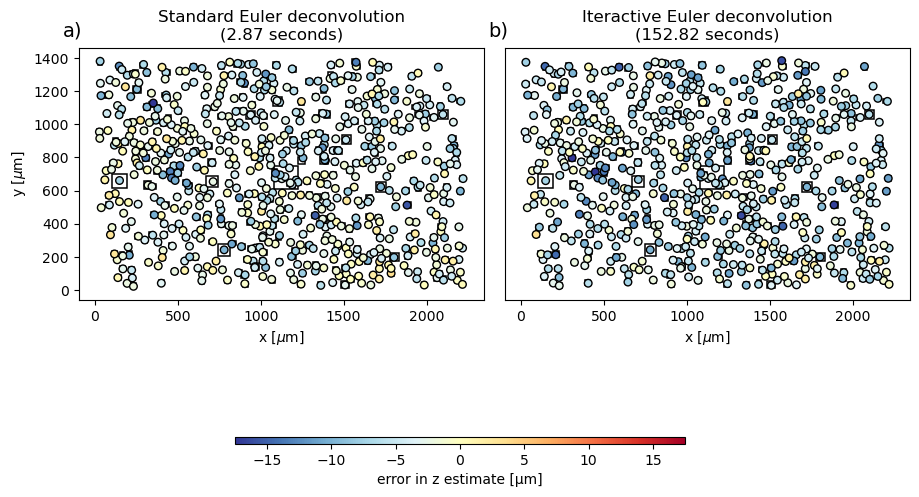

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

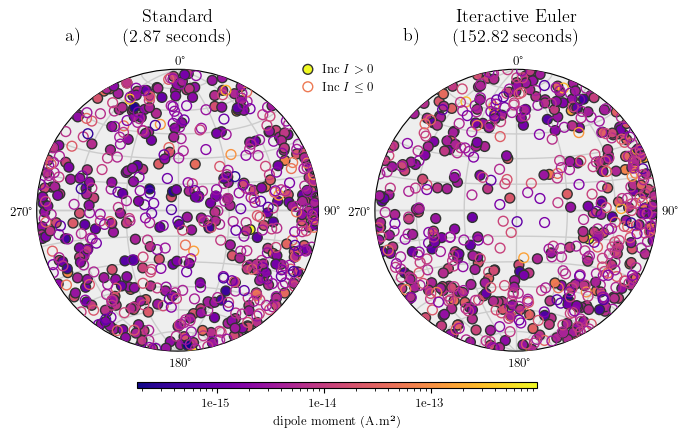

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

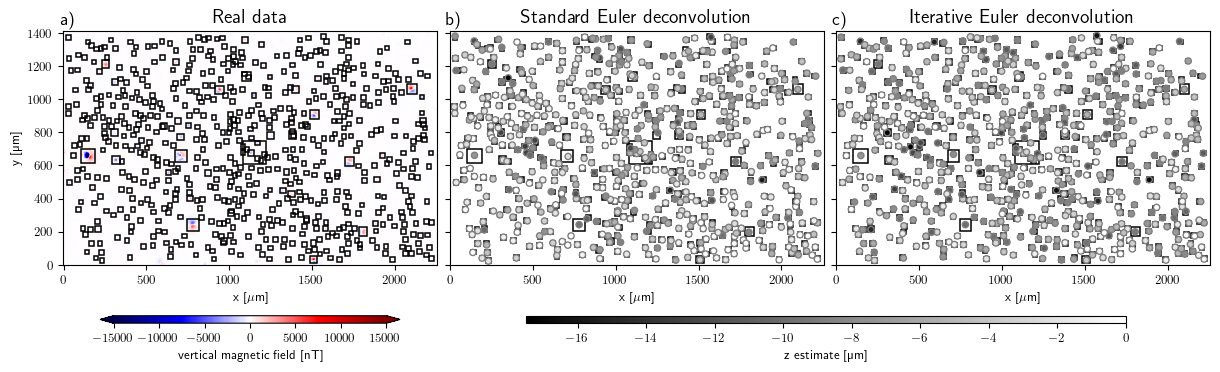

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


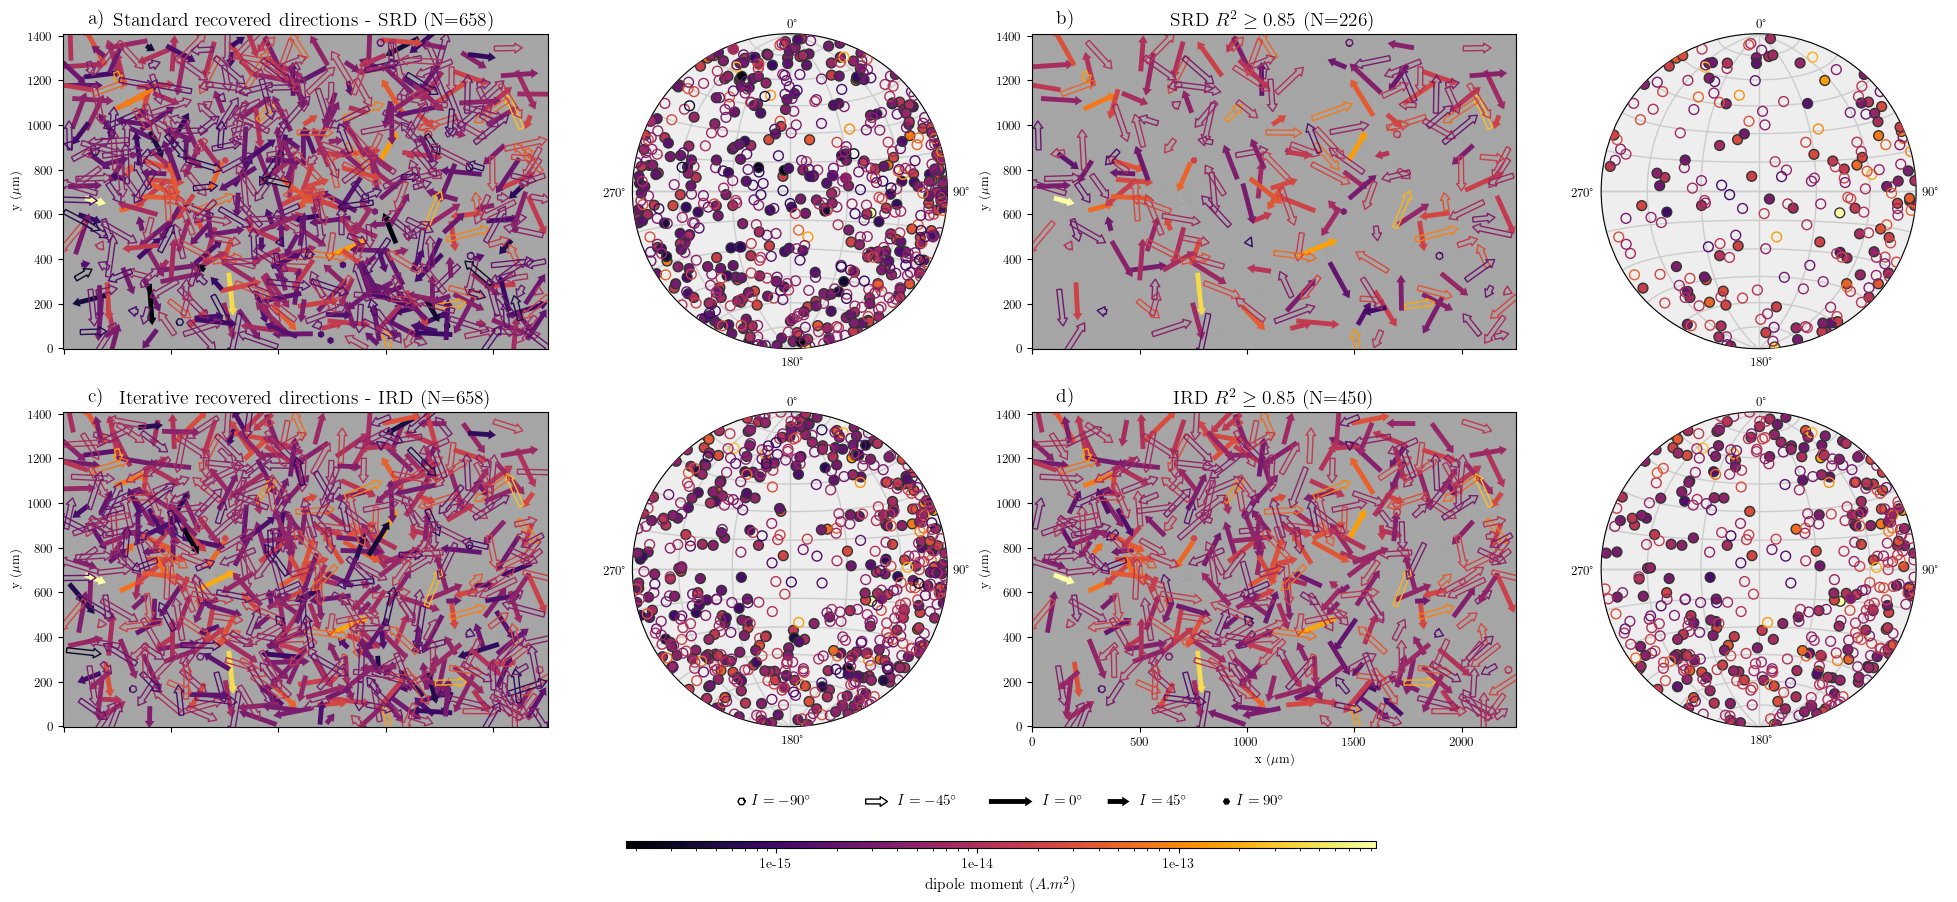

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

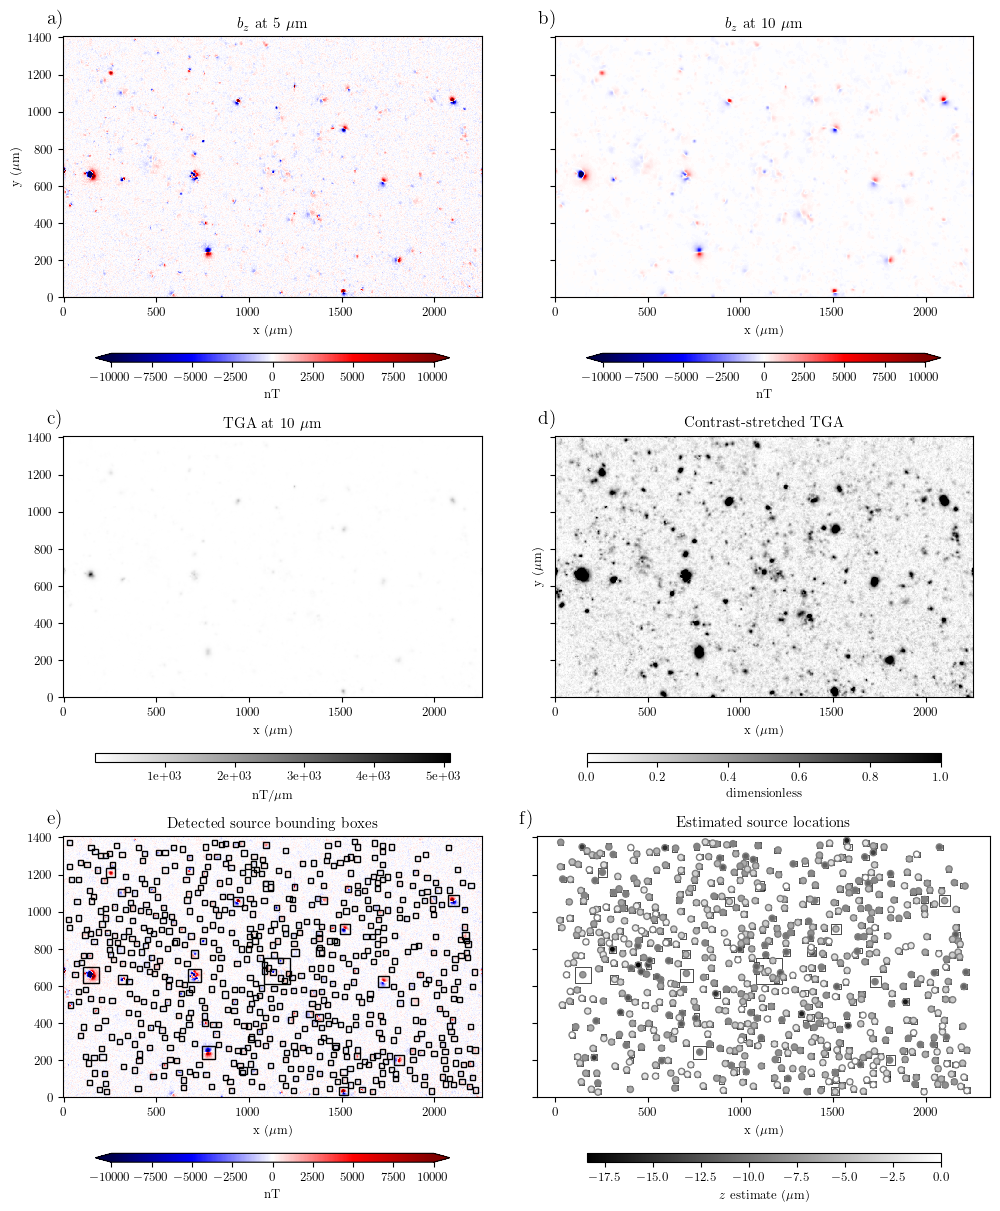

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [30]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [31]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 49.53 44.45 61.59 77.65 ... 181.3 115.5 73.03
    tga      (y, x) float64 5MB 8.1 12.66 7.756 13.35 ... 44.17 35.7 24.71 19.2
    x_deriv  (y, x) float64 5MB -2.163 2.567 7.065 ... -29.11 -23.04 -18.08
    y_deriv  (y, x) float64 5MB -1.248 0.2789 -0.9976 ... 12.53 8.624 3.898
    z_deriv  (y, x) float64 5MB 7.705 12.39 -3.043 -12.6 ... -16.43 2.367 5.166

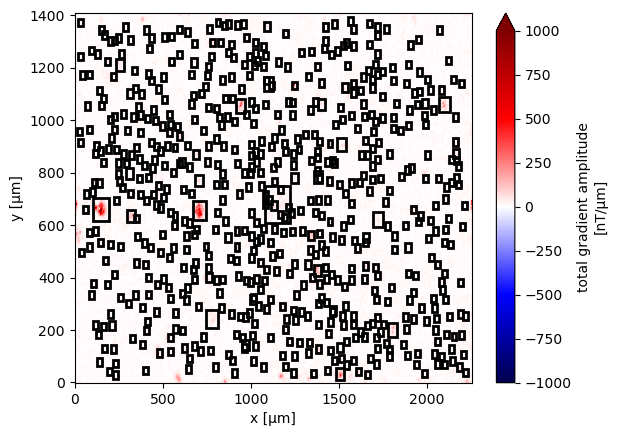

In [32]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [33]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [34]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.1,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [35]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

501 potential sources detected within 1.3275 seconds


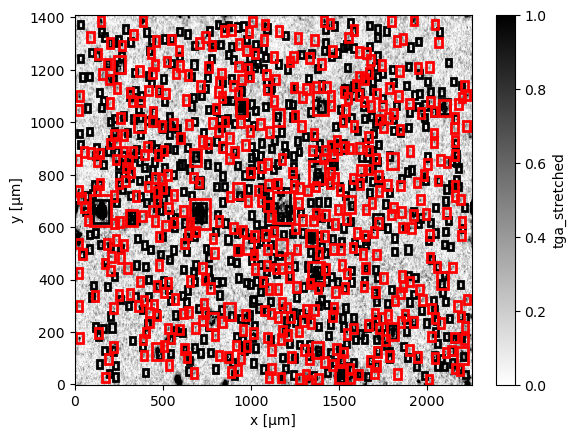

In [36]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [38]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 367.01522369  403.78477631 1368.11522369 1404.88477631]
[1151.91522369 1188.68477631    7.46522369   44.23477631]
[ 129.66522369  166.43477631 1368.11522369 1404.88477631]
[1908.61522369 1945.38477631 1370.46522369 1407.23477631]
[1549.06522369 1585.83477631    5.11522369   41.88477631]
[2211.76522369 2248.53477631 1086.11522369 1122.88477631]
[1257.66522369 1294.43477631    2.76522369   39.53477631]
[  2.76522369  39.53477631 519.76522369 556.53477631]
[   7.46522369   44.23477631 1081.41522369 1118.18477631]
[  2.76522369  39.53477631 719.51522369 756.28477631]
[  7.46522369  44.23477631 157.86522369 194.63477631]
[1894.51522369 1931.28477631  578.51522369  615.28477631]
[2209.41522369 2246.18477631  305.91522369  342.68477631]
[2197.66522369 2234.43477631  200.16522369  236.93477631]
[1055.56522369 1092.33477631 1295.26522369 1332.03477631]
[  5.11522369  41.88477631 280.06522369 316.83477631]
[1781.71522369 1818.48477631 1368.11522369 1404.88477631]
[778.

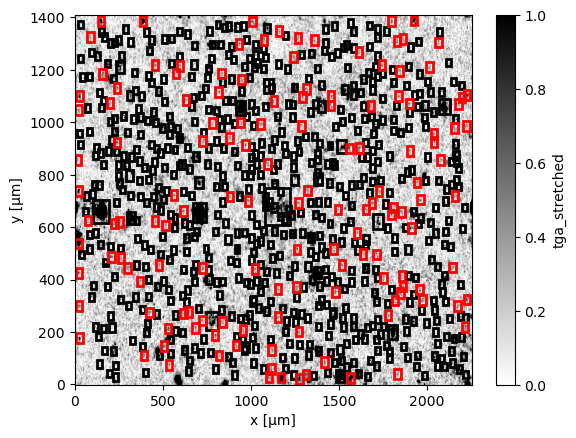

In [39]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [40]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[3.84326385e+02 1.38598041e+03 1.46316045e-02]

[3.83194010e-15 3.91457683e-15 3.29735248e-16]

(-3.444673979660337, 44.388814844596084, 5.487841287041254e-15)

0.9675452738009498

[1172.43208318   24.40388249   -1.77176345]

[ 1.51473328e-14  5.80629829e-15 -1.39631322e-15]

(4.919610508758942, 69.02709780297282, 1.6282029378928498e-14)

0.9897256303773864

[ 152.243418   1386.11164504   -4.74412741]

[-4.94351590e-15 -1.12534449e-15  2.89377433e-15]

(-29.71624817662086, -102.82430192890818, 5.837694714447884e-15)

0.8254568064723717

[1932.90414977 1386.03453079   -7.56944499]

[-7.22500176e-15  9.67227077e-15  4.84312828e-15]

(-21.858631950221653, -36.75902972633756, 1.3008049956667754e-14)

0.8363981546087549

[1563.8676248    21.99385885   -8.50249146]

[ 2.00142762e-14  9.73570924e-15 -2.11437565e-16]

(0.5442937097037547, 64.05993998716349, 2.2257582816539685e-14)

0.9233071726383978

[ 2.22869496e+03  1.10432872e+03 -1.82964092e+00]

[-2.47570316e-15 -6.26990148e-16 -1.36692189e-15]

(28.157324039723473, -104.21176515585981, 2.896670198164262e-15)

0.9103584719985109

[1277.99052354   18.42193251   -6.72835874]

[5.20020769e-15 9.90716760e-15 2.99774805e-15]

(-14.998373854375659, 27.694688227018588, 1.1583636012914363e-14)

0.9514922171265955

[ 19.82683886 546.16359673  -1.87207954]

[ 3.21452161e-17 -9.35696651e-15  8.38987512e-16]

(-5.12366434710973, 179.8031650569426, 9.394559890517079e-15)

0.8816875577382163

[  24.65320709 1099.87782814   -3.89125586]

[ 2.02516380e-15  3.14463384e-15 -1.36209025e-15]

(20.00979651256647, 32.78178772222052, 3.98061556558356e-15)

0.8144097909180887

[ 18.91124512 737.20968447  -2.95060014]

[ 1.20719622e-16 -3.44238656e-15  1.32090255e-15]

(-20.980887631997252, 177.99154121213616, 3.6890895931472294e-15)

0.905323856921377

[ 23.74665128 175.03339347   0.60446216]

[-7.66574139e-16  3.23172815e-16 -4.67013677e-16]

(29.30873440639483, -67.14065381847303, 9.540326799029728e-16)

0.817216924280685

[1915.06611412  601.36142716   -6.31400819]

[-1.31493636e-15 -3.39860198e-15 -1.79313396e-15]

(26.20010769138595, -158.84829295855468, 4.061389221259376e-15)

0.6922977686572022

piorou

[ 2.23107015e+03  3.19864388e+02 -5.46955606e-01]

[ 1.35742355e-15  1.00096875e-17 -5.39873363e-16]

(21.688129039087862, 89.57750662861358, 1.4608771786784768e-15)

0.5068799714641341

piorou

[2.21299778e+03 2.19721589e+02 3.01827300e-01]

[ 5.19485710e-16  5.84831894e-16 -1.81447997e-17]

(1.328797891070965, 41.613564975473814, 7.824467908259676e-16)

0.23127210327087033

[1070.24564007 1317.32120861   -8.61626228]

[ 5.74781543e-15 -4.82411612e-15  3.16745273e-15]

(-22.884798936363577, 130.00658788695662, 8.145074298515487e-15)

0.8995948689092599

[ 21.40961646 299.05651465  -4.47651892]

[-7.22169444e-16 -1.05233955e-15 -1.78412164e-15]

(54.42131116531077, -145.5400855462353, 2.1936356268175362e-15)

0.8161622346318037

[1799.11487662 1388.45981799   -7.6404282 ]

[ 4.48126162e-15 -2.69138428e-15  2.65067814e-15]

(-26.888569554260354, 120.98845005593678, 5.8610024416624675e-15)

0.9035680997213668

[795.82967348 186.30811668  -8.67041381]

[-4.88988934e-15 -4.64371545e-15  2.81716649e-17]

(-0.2393567817479914, -133.52085416385393, 6.743582473386949e-15)

0.8364143379776827

piorou

[ 2.10901906e+02  4.87200077e+02 -4.24271046e-01]

[-8.17458419e-16 -8.89753548e-16  5.99519783e-18]

(-0.28428967401509503, -137.4248496780068, 1.2082779417706846e-15)

0.3607282014127765

[ 20.80411234 429.07095743  -3.72773642]

[ 3.09832689e-16 -1.92259403e-15  1.04959499e-15]

(-28.323453769834636, 170.84529567449084, 2.2122417891287973e-15)

0.7765874566041218

[528.80404213 211.72542998  -3.45527883]

[4.28341359e-16 2.93829757e-15 4.36933362e-17]

(-0.8430326184425596, 8.294082902622636, 2.969676420022806e-15)

0.8337976427630654

[1007.24068437 1388.32502073  -13.80877541]

[-1.66695492e-15  1.14813013e-14 -9.52975268e-15]

(39.40007053679384, -8.260974628556768, 1.5013833740966675e-14)

0.904539980140499

piorou

[1.61899025e+03 9.02066421e+02 3.10378740e-01]

[ 8.47012835e-16  1.53570035e-17 -6.80184285e-16]

(38.76122381492836, 88.96129662747309, 1.0864240618145283e-15)

0.6512454223826478

[1320.91733681   22.98633264  -10.71699929]

[-1.23998698e-14  2.22449088e-14 -4.22975090e-15]

(9.429857454936618, -29.136391310199986, 2.5816342294787343e-14)

0.7866010731933487

[  22.7506196  1046.98977923   -7.35524161]

[ 4.26159275e-15 -8.45437608e-16 -9.48485486e-16]

(12.315103003686385, 101.22095096421194, 4.446972253107497e-15)

0.8294989736476397

[421.80455378 271.34878012  -5.95676012]

[-8.39083055e-16  3.48348030e-15  6.74937470e-16]

(-10.667594588444281, -13.543123151038603, 3.646126158373269e-15)

0.70170809396496

[955.65565867 206.19218543  -7.30563323]

[ 2.88464763e-15 -4.76830858e-15  7.67640570e-16]

(-7.842774976223913, 148.82763686434134, 5.62558714366308e-15)

0.8513272030967787

[1900.13568468 1070.00639595   -2.62847396]

[-1.45728689e-15 -2.28259325e-16  8.06995300e-16]

(-28.682850509746267, -98.90208336080424, 1.6813770548564887e-15)

0.803531842073981

[ 243.84649781 1131.19386879  -15.28701197]

[-9.72309366e-16 -1.67079432e-14 -4.65235628e-15]

(15.534944474680792, -176.66946064612776, 1.7370813766504002e-14)

0.8233184198011214

[1054.15623324  994.64348739   -6.25693008]

[ 9.76574790e-16 -1.75442442e-15  2.59425565e-15]

(-52.26073210981234, 150.8981378492818, 3.2805282682649367e-15)

0.7578644156416879

[1843.64019475 1098.8381748    -2.23106032]

[-2.00835199e-15  4.52130805e-16  2.11927651e-16]

(-5.8777036563458855, -77.31278454040427, 2.0694959105725234e-15)

0.8478917046723123

[1750.89201409 1222.52180524   -9.14982817]

[ 6.17926571e-15 -2.93403210e-15 -2.47827872e-15]

(19.915308820492495, 115.39925103019529, 7.275557330012305e-15)

0.8820908785637737

[1091.84314404  847.70011919   -4.77313847]

[-1.83190683e-15  8.27316208e-16 -1.77507464e-15]

(41.44759624631789, -65.6953611861476, 2.6816458968121492e-15)

0.7782672828377816

[1018.42441301  436.0607502    -8.80584066]

[-5.68098112e-15 -1.74798355e-15 -2.23604611e-15]

(20.616140387495733, -107.10263095169178, 6.3505035410039654e-15)

0.849066677584153

[1449.81139537 1064.92712045  -16.37510499]

[-2.62965343e-14  3.96269913e-15 -1.85489429e-15]

(3.989923539484959, -81.43041571116159, 2.665804447641132e-14)

0.9442953252031249

[ 80.26724878 630.41408965  -0.96615895]

[ 6.87289056e-16  2.94780527e-17 -5.04880640e-16]

(36.27578282035677, 87.54407047484136, 8.533110000923459e-16)

0.4773832469561239

[ 455.33477607 1214.80539678   -8.29543508]

[ 3.90265285e-15 -3.11016239e-15 -2.98648931e-15]

(30.89842325764066, 128.55258344831168, 5.815748248153659e-15)

0.744502073716125

[647.34629789 276.64601999  -4.85072013]

[-3.47046406e-15 -1.42069898e-15 -4.09891282e-16]

(6.237912359180337, -112.2626513179998, 3.772335781110374e-15)

0.8648601172421237

[1960.59222463  364.42126692   -7.46794118]

[ 4.66641790e-15 -1.46262904e-15  3.58297217e-16]

(-4.190423598658055, 107.4029326597337, 4.903378079435454e-15)

0.7534056642398402

[2158.24542778  973.29848977   -9.42832359]

[-2.35022318e-15 -8.54668494e-15 -1.14055947e-15]

(7.332196097968058, -164.6244666257762, 8.937015625894893e-15)

0.9168660858460859

[1451.67976998 1102.33275339   -3.56628164]

[ 2.53070415e-15 -1.08882662e-15  4.86026322e-16]

(-10.004963111498496, 113.27962345498207, 2.7975397218138884e-15)

0.9079456542782557

[ 195.44075873 1074.70829869   -8.24173389]

[-4.07126672e-15 -8.28292750e-17 -3.19563636e-15]

(38.12347370575246, -91.16551274737125, 5.1763080606643694e-15)

0.8443213007299355

piorou

[ 1.72550845e+03  7.40524686e+02 -1.28591660e+00]

[ 1.20819815e-15 -5.22867612e-16 -4.82478567e-16]

(20.12737651401272, 113.40134148794954, 1.4021122902239024e-15)

0.5726891654905593

[1248.62763808 1258.35986979  -11.79407296]

[ 8.98154801e-15  5.88282483e-15 -3.66732397e-15]

(18.85864488705216, 56.7755990523677, 1.1345708340367994e-14)

0.5199366865297825

piorou

[ 7.22792510e+02  4.48876205e+02 -2.77000050e-01]

[ 3.00419115e-16 -6.02017502e-16  1.87252452e-16]

(-15.552574364806905, 153.47986034993934, 6.983839899757297e-16)

0.18369505794544538

[1847.78554483  353.19434321   -2.24141077]

[-2.78686765e-16 -1.65013349e-15  3.47014904e-16]

(-11.714753629803354, -170.41392243095063, 1.7091009888109398e-15)

0.6825050527308667

[730.20255595 928.69220811 -10.24964707]

[-6.54417762e-15 -4.97250548e-15  1.57685118e-15]

(-10.860469912786376, -127.22889801215592, 8.368902620705804e-15)

0.8130556410036307

[873.90751536 943.90134273  -6.0218171 ]

[-2.00067323e-15  6.42568219e-16 -2.54899792e-15]

(50.498686426412576, -72.19422836071656, 3.3034796330973143e-15)

0.7673764256175056

[ 1.97471474e+03  3.20745126e+02 -1.82870600e+00]

[-5.27336674e-16 -3.65736392e-16  9.88878973e-16]

(-57.01762466386886, -124.74339234939328, 1.1788675497688087e-15)

0.589530602320451

piorou

[259.27778201 616.25877147  -1.46539945]

[ 6.38613243e-16 -7.50351040e-16 -3.58586958e-17]

(2.084244365896211, 139.59935998416148, 9.859712988212792e-16)

0.1292694335434228

[1263.34406408  375.66344858   -3.63804119]

[ 2.64369154e-15  9.00803868e-16 -9.47698495e-16]

(18.743023749835817, 71.18411722095748, 2.949353318092693e-15)

0.7365210066339044

[366.82083417 393.76046531  -2.52435438]

[ 1.38833935e-15  1.26952125e-15 -5.81989347e-18]

(0.17724971613017051, 47.55966996053625, 1.8812772872851184e-15)

0.7626086110107566

[1147.71810688  372.05423526   -3.37710293]

[ 2.10040248e-15 -4.67369010e-16  7.91882218e-16]

(-20.204318299801642, 102.54473900981465, 2.2928588734132916e-15)

0.6335136530911005

[1128.14647915 1082.2083697    -6.71874551]

[-3.05880614e-16  2.16446523e-15 -3.09633256e-15]

(54.778389869230246, -8.043731649652905, 3.790217405722531e-15)

0.8920885159585906

[983.17220447 700.16181445 -17.56152772]

[ 1.57916103e-14 -1.98052169e-14 -7.35987593e-16]

(1.6642994771452468, 141.43303355139872, 2.5340940191984792e-14)

0.880411934644059

[1107.82129228   27.87669182   -5.22475604]

[ 3.36944022e-15 -1.43102035e-15 -1.33912420e-15]

(20.092920549032453, 113.01120650882591, 3.897973864121881e-15)

0.8092991883483096

[2164.13150455  721.5198644    -7.1202193 ]

[-1.41751259e-16  4.25766500e-15 -2.11631639e-15]

(26.417500876787592, -1.9068550567310525, 4.756742559897889e-15)

0.8936706348931844

piorou

[1275.21313885  690.25253172   -1.60712246]

[-1.34396264e-15 -3.24624394e-17  6.36689252e-16]

(-25.342335987286294, -91.38366880843776, 1.4875021293141993e-15)

0.53365969023908

[2175.44786051  293.05581162   -5.60588753]

[ 8.24728059e-16 -2.34419877e-15 -1.54598783e-15]

(31.886439435229764, 160.61728125640022, 2.9266914123910267e-15)

0.731163082451065

piorou

[ 1.40634507e+03  8.82395490e+01 -9.88390268e-01]

[ 4.00552986e-16  7.03209057e-16 -6.64150255e-16]

(39.37438507668122, 29.66615323094394, 1.0469198788793748e-15)

0.27000960576300226

[ 623.63017292 1089.30769021   -3.64201498]

[-1.26493424e-15  1.16219416e-15 -9.72815653e-16]

(29.523867327412926, -47.42387701975667, 1.974113516089824e-15)

0.602614266267259

[562.29255615 728.08315036  -8.67493841]

[-2.14939644e-15 -2.79195835e-15  2.94085486e-15]

(-39.849865404117175, -142.40903051798065, 4.58950583365013e-15)

0.7283035625561334

[964.52697104 911.48616611  -3.38736261]

[-2.09590061e-15 -5.13420526e-16 -9.13879840e-16]

(22.953157068092054, -103.76436331459057, 2.343411267107378e-15)

0.8820277298977993

[844.49323282 236.5405493   -4.96056443]

[-2.03231176e-15 -2.08265305e-15  1.00479360e-15]

(-19.049657267607245, -135.70090501282615, 3.078529678499643e-15)

0.8043520155120496

[1963.69684438  708.7907855    -2.32738286]

[-6.60623000e-18 -1.51985625e-15  5.74615637e-17]

(-2.1651433963308473, -179.75095887206825, 1.5209564360947056e-15)

0.7156201397626483

[1803.17192101  646.28563082   -5.70617734]

[-3.03860304e-15  1.28682313e-15  1.79192295e-15]

(-28.50334670394976, -67.04774612726354, 3.754998015219364e-15)

0.7741317111797661

[942.67632103 991.83909121  -9.99009928]

[-3.76352101e-15  5.42504350e-15  9.61113563e-16]

(-8.282061349250624, -34.750245423900616, 6.672250498263447e-15)

0.7456420613880805

[ 812.89676229 1115.41379425  -12.4184935 ]

[5.56051135e-15 6.75043986e-15 1.79079007e-15]

(-11.572024734471306, 39.47916350470378, 8.927186221322102e-15)

0.7485216351205657

[ 15.01911916 857.14796698  -3.4494357 ]

[-1.65634145e-16 -1.59887362e-15  1.01400550e-15]

(-32.24471313014193, -174.08558276060032, 1.9005364184435658e-15)

0.8529424487526718

[1709.75537657  491.71849553   -7.92086884]

[3.82998273e-15 1.59903418e-15 3.09631256e-15]

(-36.724064408153815, 67.33925494616089, 5.178110612341716e-15)

0.7812839507972127

[613.2857638  268.45962741  -4.34876303]

[-2.20339579e-15  1.65492531e-15 -1.80243080e-16]

(3.742272816954008, -53.09053998891462, 2.76156086082674e-15)

0.7604663624749369

[728.41969816 245.10148219  -2.14526284]

[-9.45566284e-16 -5.91312972e-16  8.96485537e-16]

(-38.79421024250067, -122.01993629878028, 1.4308853715561316e-15)

0.7857810644737908

[9.16661178e+02 1.50384822e+02 1.29397945e-02]

[ 1.16768519e-16 -8.71205996e-16  5.94744641e-17]

(-3.870834522905965, 172.36609103707755, 8.810062350350417e-16)

0.6852993316764975

[1611.36634764 1265.6198236    -4.71648242]

[1.36643977e-15 1.71684873e-15 1.18691878e-15]

(-28.40995912486646, 38.51627925755613, 2.4946950524813373e-15)

0.7921477545846197

piorou

[ 1.51100892e+03  4.59877751e+02 -1.56248722e-01]

[-7.95374332e-16  2.56357790e-16  1.91817274e-17]

(-1.3149242734384095, -72.1353048576106, 8.35887302965307e-16)

0.3551893971894119

piorou

[5.19595226e+02 6.03373314e+02 5.76247053e-02]

[ 7.35321110e-17  6.69772279e-16 -7.55784342e-17]

(6.400002888843234, 6.2652250488845675, 6.780221062255064e-16)

0.43287584244941957

[1146.13973129  261.00629719   -5.54558569]

[-8.56001014e-16 -2.38229517e-15 -1.75771827e-15]

(34.77462987129887, -160.23573483905, 3.0818243876189394e-15)

0.7286654471190628

[239.55164614 921.59253504  -7.26325692]

[-2.62382874e-15  2.72860841e-15  2.99717622e-15]

(-38.3707046567585, -43.87851725927591, 4.828337849602538e-15)

0.7429590734159137

[1849.41813472 1193.43949699  -11.24946206]

[ 2.93121116e-16 -1.01226467e-14 -2.23819680e-15]

(12.46288929515458, 178.34135166973937, 1.0371278679906783e-14)

0.8795970276276953

[1871.58721648  374.18217961   -6.38734144]

[-3.25426479e-15 -1.92743160e-16  2.13653253e-15]

(-33.2402154499597, -93.38954704200802, 3.897712212373999e-15)

0.7737957283097732

[2182.48868301 1072.11270847   -7.34332044]

[ 1.67281217e-15  3.51075807e-15 -1.99168488e-15]

(27.118939262663755, 25.476947808409296, 4.3692712720798e-15)

0.9234903777964799

[301.58389545 441.10732351 -16.5943715 ]

[ 2.73004584e-14  1.12472657e-14 -5.25405769e-15]

(10.08980853043196, 67.60927753146505, 2.9990350784845635e-14)

0.9399371690778986

[456.74479746 621.28892658  -3.71504391]

[-1.04366406e-15 -1.07666342e-15 -1.17937202e-15]

(38.18579151188767, -135.8916411272649, 1.90770991981521e-15)

0.7484265287346527

[395.43785542 112.26472368  -8.07229087]

[ 3.16455576e-15 -2.72864972e-15  1.33222640e-15]

(-17.683744534032144, 130.7696747127274, 4.385746190154396e-15)

0.7234503332526103

piorou

[690.86669095 216.91221215  -2.0272037 ]

[-8.28647539e-16 -6.10502920e-16  4.69624604e-16]

(-24.526039339999716, -126.38079004720854, 1.1313345336377401e-15)

0.21965266978407216

[1319.42017716 1129.44363341   -6.36777302]

[ 2.52537049e-15  2.13030077e-15 -1.76704354e-15]

(28.13954497123857, 49.85037022501993, 3.7467479705391414e-15)

0.8566225761760234

[1476.87309869  354.15111791   -2.12434947]

[-2.82943022e-16  1.08018155e-15 -8.06553276e-16]

(35.84111546806795, -14.678295791571829, 1.377453127133844e-15)

0.6692136070128987

piorou

[ 1.12123743e+03  6.11139585e+01 -4.21709734e-01]

[-1.03058400e-17  1.23248759e-15  7.81282168e-17]

(-3.6270382852491916, -0.47908585895768235, 1.2350044041829702e-15)

0.5373435540982783

[536.57860626  64.90073656 -10.52439137]

[-4.85713091e-15 -5.96089806e-15  9.45699449e-16]

(-7.011616997369245, -140.82574782963118, 7.747152628882574e-15)

0.7590605307334151

[ 830.04841096 1183.54180695   -5.09579418]

[ 3.27766065e-15 -1.28956178e-15  1.01241034e-15]

(-16.036521853758458, 111.47664528942774, 3.664833372216173e-15)

0.9054544307934133

piorou

[1839.9415597    35.35415823   -3.51297401]

[ 2.70930003e-15 -3.56198730e-16 -5.53315016e-16]

(11.446800656834483, 97.48986822935746, 2.788071318782702e-15)

0.47843555205030797

[1553.7076883   899.0440779    -8.18207928]

[-5.28373551e-15 -6.47921050e-15 -2.24282857e-15]

(15.016867768964259, -140.80307831261533, 8.656114003685363e-15)

0.8344790873361019

[ 2.08144516e+03  8.54786047e+02 -1.08303448e+00]

[-3.42901316e-16  7.44505086e-16  5.42058818e-16]

(-33.47700067557669, -24.729671945978417, 9.826987828604085e-16)

0.6253985202495661

[2045.20598957  927.88903782   -3.42360559]

[ 6.06065010e-17 -2.05935164e-15  4.71984702e-16]

(-12.903329477773413, 178.31427783494803, 2.113615833111554e-15)

0.6815732267298479

[ 165.1255771  1182.60281107  -16.36421281]

[ 3.19600928e-14  1.84294368e-15 -7.25448621e-15]

(12.76811781035796, 86.69975642933075, 3.282486169978565e-14)

0.9069303517066233

[1120.20662228  128.16511397   -7.14539397]

[-4.18065857e-15  2.46061995e-15  1.87478941e-15]

(-21.130116885223153, -59.520110740061824, 5.2007107196650015e-15)

0.9065023208112148

piorou

[1676.09316187 1057.34074324   -8.21780178]

[ 1.42978494e-15  7.09825140e-15 -3.05534845e-17]

(0.24176482735246013, 11.38856958706021, 7.24088333302961e-15)

0.5250806197938065

[ 1.83193685e+03  1.30640468e+03 -1.16064749e+00]

[-4.15707380e-16 -1.05944168e-15  2.96408845e-16]

(-14.598153883355515, -158.57577940283215, 1.176047406619392e-15)

0.6673091882725275

[1267.48407034 1326.42407425   -9.37157936]

[ 1.27052365e-15  5.95388425e-15 -2.96487393e-15]

(25.966454642733265, 12.045904140017454, 6.771517221353951e-15)

0.6677022669916812

[1656.84443062  672.17723208   -7.14939841]

[ 1.73946478e-15 -3.62218408e-15  2.09231087e-15]

(-27.506358447927276, 154.3484992542719, 4.530311249354386e-15)

0.8181321361990449

[817.97434766 110.14191959  -4.77773474]

[-3.23070687e-16  2.66207649e-15 -9.19674777e-16]

(18.929730529246047, -6.919600103968169, 2.8349299134123406e-15)

0.7735453394558927

[ 1.90292419e+03  8.86349753e+02 -1.24759829e+00]

[-1.33730229e-16  1.17897967e-15 -8.43176842e-17]

(4.0647097051997605, -6.471331554829922, 1.189531970527202e-15)

0.6993955869700355

[626.91679162 665.3822267   -9.91721949]

[-8.61451391e-15  3.85093192e-15  1.55073818e-15]

(-9.332647913887394, -65.91400296629759, 9.562652111153265e-15)

0.7428290549504485

piorou

[2.14201116e+03 4.50108650e+02 2.57943867e-01]

[8.36903818e-16 4.26753557e-16 4.15738447e-16]

(-23.871489961089537, 62.982079888333516, 1.0273096200781489e-15)

0.483439807288063

[1269.18811858  206.16184061   -7.6074175 ]

[ 2.65766454e-15 -2.70332135e-15  1.37995105e-15]

(-20.00222185819042, 135.48794743102582, 4.034277140557999e-15)

0.6089949744689966

[226.20706503 613.56322153 -20.15126116]

[ 1.74173093e-14 -2.80437331e-14  7.39961678e-15]

(-12.633861762786275, 148.15654744293948, 3.3831464034663224e-14)

0.9084037222613268

piorou

[9.18931134e+01 1.32060426e+03 5.11192309e-01]

[-2.24107745e-17  7.12628943e-16  1.18378648e-16]

(-9.427011654335166, -1.8012455979637902, 7.227418328906177e-16)

0.4714416119657796

[2231.00095205  985.70513618   -9.38811042]

[ 8.45081551e-15  3.77728400e-15 -1.72036638e-15]

(10.528493134502023, 65.91665937602012, 9.415084581931465e-15)

0.9194422039703325

piorou

[ 9.46608480e+02  1.15252248e+03 -6.57943640e-02]

[-7.88077855e-16  1.18326086e-16 -3.78543893e-16]

(25.40836228443156, -81.46109978623296, 8.822489706524521e-16)

0.32783745683888676

[2018.06237422 1203.41381014   -7.48746933]

[ 2.15850520e-15 -1.46874476e-15 -2.18559854e-15]

(39.93379997520044, 124.23314572992103, 3.4048783898325896e-15)

0.7351027516659894

[ 930.04886116 1294.79389032  -11.32973015]

[8.37558778e-15 5.31266399e-15 6.66724610e-16]

(-3.8456890884251314, 57.612903971047636, 9.940794285533344e-15)

0.8406463964482352

[1779.18504737  257.82484727   -5.27926872]

[-5.69840753e-16 -3.35883217e-15 -9.53319074e-16]

(15.633004886617357, -170.37119943319712, 3.537695480218927e-15)

0.7561379673508959

piorou

[ 1.94381989e+03  7.66844070e+02 -1.80050390e+00]

[9.41393823e-16 1.27780163e-15 4.71725064e-16]

(-16.55289028229606, 36.38016036032485, 1.655754775521329e-15)

0.479039701972642

[2067.77465192 1299.56641153   -8.54360183]

[-1.56959998e-15 -6.00097862e-15 -9.81057846e-16]

(8.98758612416841, -165.34223671680883, 6.279957242807525e-15)

0.9226951704768295

[1687.21258898  691.2289519    -7.68199137]

[ 6.68043925e-15 -6.60054087e-17  1.13332322e-15]

(-9.627981934813459, 90.5660867718316, 6.776211833875497e-15)

0.9023008316752824

[ 594.36590086 1217.51191575   -4.3068397 ]

[-8.94362417e-16  6.36283759e-16 -1.38539946e-15]

(51.61135747838118, -54.570492628925564, 1.7675046865678044e-15)

0.8597919259473412

[1818.19128102  320.76437565   -7.3812622 ]

[ 4.39430430e-15 -2.85683146e-16  1.37704018e-15]

(-17.36494279041795, 93.71968686475974, 4.613866581089389e-15)

0.7447148217198452

[478.32804095 463.1893189   -5.19688422]

[ 9.59180793e-17 -2.19215348e-15  1.51182887e-15]

(-34.566664384396944, 177.49461066127904, 2.6646507605776784e-15)

0.7177678040654276

[1316.85267101  727.94295204  -15.06840428]

[-1.60189550e-14 -1.44328192e-14 -5.25436444e-15]

(13.695367350319135, -132.018340103246, 2.219282615499302e-14)

0.7905106970907065

[1858.47943937  411.46147524   -4.64552021]

[-2.81622800e-16  1.82482954e-15  1.49583042e-15]

(-39.01159107735639, -8.773145291320274, 2.3763044622719367e-15)

0.7586052202516633

[1165.33112564 1350.53154052   -8.90127798]

[2.34744022e-15 5.13545151e-15 1.09465825e-15]

(-10.971479555573834, 24.56537399134409, 5.751661883588074e-15)

0.868909601609414

[504.88928322 150.53025857  -5.20236316]

[ 1.50072819e-15 -3.71007393e-15  1.37174543e-15]

(-18.919463717470293, 157.97662428813717, 4.230664151445264e-15)

0.8424185472639178

[ 1.49931518e+03  6.68126959e+02 -7.37259222e-02]

[ 6.74613385e-16 -3.64955768e-16 -3.96794400e-16]

(27.353878702132672, 118.41272623387474, 8.635633895754919e-16)

0.6208017541339645

piorou

[ 2.20121268e+03  1.09488023e+03 -1.03180840e+00]

[-7.58848728e-17  2.17158168e-17  1.10826577e-15]

(-85.92626092008875, -74.03057683253442, 1.1110729561242104e-15)

0.770049765209505

[ 574.78369112 1186.56849954   -2.43387318]

[1.56218248e-15 4.69465259e-16 4.29080998e-16]

(-14.737583260466208, 73.27348710911525, 1.6866897234201138e-15)

0.7919753472862062

[1599.71650591  577.54444067   -4.04768473]

[2.20721145e-15 4.95126594e-16 4.82504485e-17]

(-1.2219495664584292, 77.35658400671292, 2.262578356837651e-15)

0.890745115973907

[785.17436105 999.9209539   -7.17018447]

[ 3.42529581e-15  2.51660004e-15 -9.70119989e-16]

(12.85705576038382, 53.694892615867445, 4.3597086951638845e-15)

0.9010334491812253

[1474.64919056  524.54985961   -2.05139256]

[ 7.45649089e-16 -9.34167308e-16 -1.24787123e-16]

(5.960151722619483, 141.4032545731954, 1.2017624345702769e-15)

0.5043856461859685

[ 2.04096212e+03  9.52954989e+02 -1.96020154e+00]

[ 5.64634794e-16 -6.52612787e-16 -8.41456529e-16]

(44.27686975052914, 139.13393115513998, 1.2053070110839836e-15)

0.7098860793665507

[1298.0228362  1087.76996144  -13.12222647]

[-9.53198955e-15 -8.18613784e-15  1.07123816e-15]

(-4.873125278054211, -130.65620980047296, 1.2610282657847461e-14)

0.6916683082252038

[1264.05824859  505.31723098  -10.42931641]

[-4.26864126e-15 -9.36548564e-15  6.85655772e-16]

(-3.811278124190952, -155.49724657805606, 1.0315219012136961e-14)

0.7083502480850582

[1863.55970746  655.28866168   -8.72254829]

[4.34716131e-15 1.59318633e-15 2.36072282e-15]

(-27.01637048435212, 69.87267577374453, 5.19702475688332e-15)

0.7763036886299641

piorou

[1364.5167672  1305.60076241   -2.78911364]

[ 1.27377359e-15 -1.41117038e-15 -7.03852835e-16]

(20.31701474876802, 137.92944490350132, 2.027143261996985e-15)

0.27150331677232475

[255.78569705 477.9970696   -5.10437354]

[3.17239835e-15 3.65391097e-16 7.86492029e-16]

(-13.835947689360754, 83.42972757803565, 3.288797902873103e-15)

0.8795204519079336

[1810.05388635  673.08425151   -6.63150794]

[ 3.21654872e-15  2.22218699e-15 -1.26854047e-15]

(17.976962467088406, 55.360930573375455, 4.1101697762382035e-15)

0.8855738944746878

[1633.47739979  498.18101599   -9.24929412]

[-3.21165784e-15  3.69422432e-15 -3.34485244e-15]

(34.34501996386418, -41.002805875109324, 5.928750053218512e-15)

0.8152958670670074

[1868.90749433 1318.69086909  -11.97708924]

[ 1.15764508e-14  7.49779307e-15 -9.47424388e-16]

(3.929567302909137, 57.0698254229503, 1.382493133006271e-14)

0.8769432492475887

[887.04733628 715.64086529  -4.93914652]

[-2.19144610e-15 -8.95081464e-16  8.47219160e-16]

(-19.692298715769454, -112.2172304176128, 2.5142368886903313e-15)

0.6320342228750724

[1754.65860434  405.17097115   -5.02554871]

[ 1.62901455e-15 -2.35307923e-15  3.58091341e-16]

(-7.131905619583792, 145.30550980677793, 2.884250281249888e-15)

0.7035542949215311

[1287.24049867  975.09943065  -12.13986794]

[-9.24804803e-15 -8.18622715e-15  8.24451328e-16]

(-3.8190113375525168, -131.5147504674445, 1.2378223914039444e-14)

0.8827176151615224

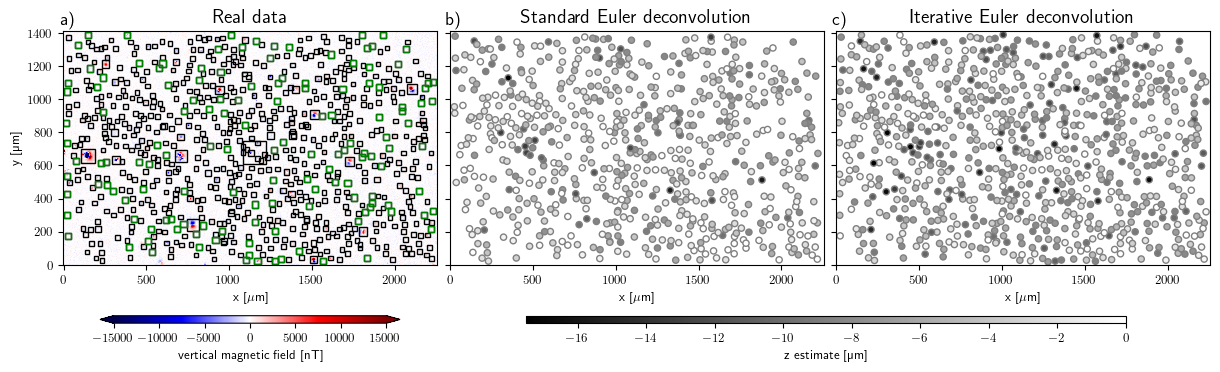

In [41]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

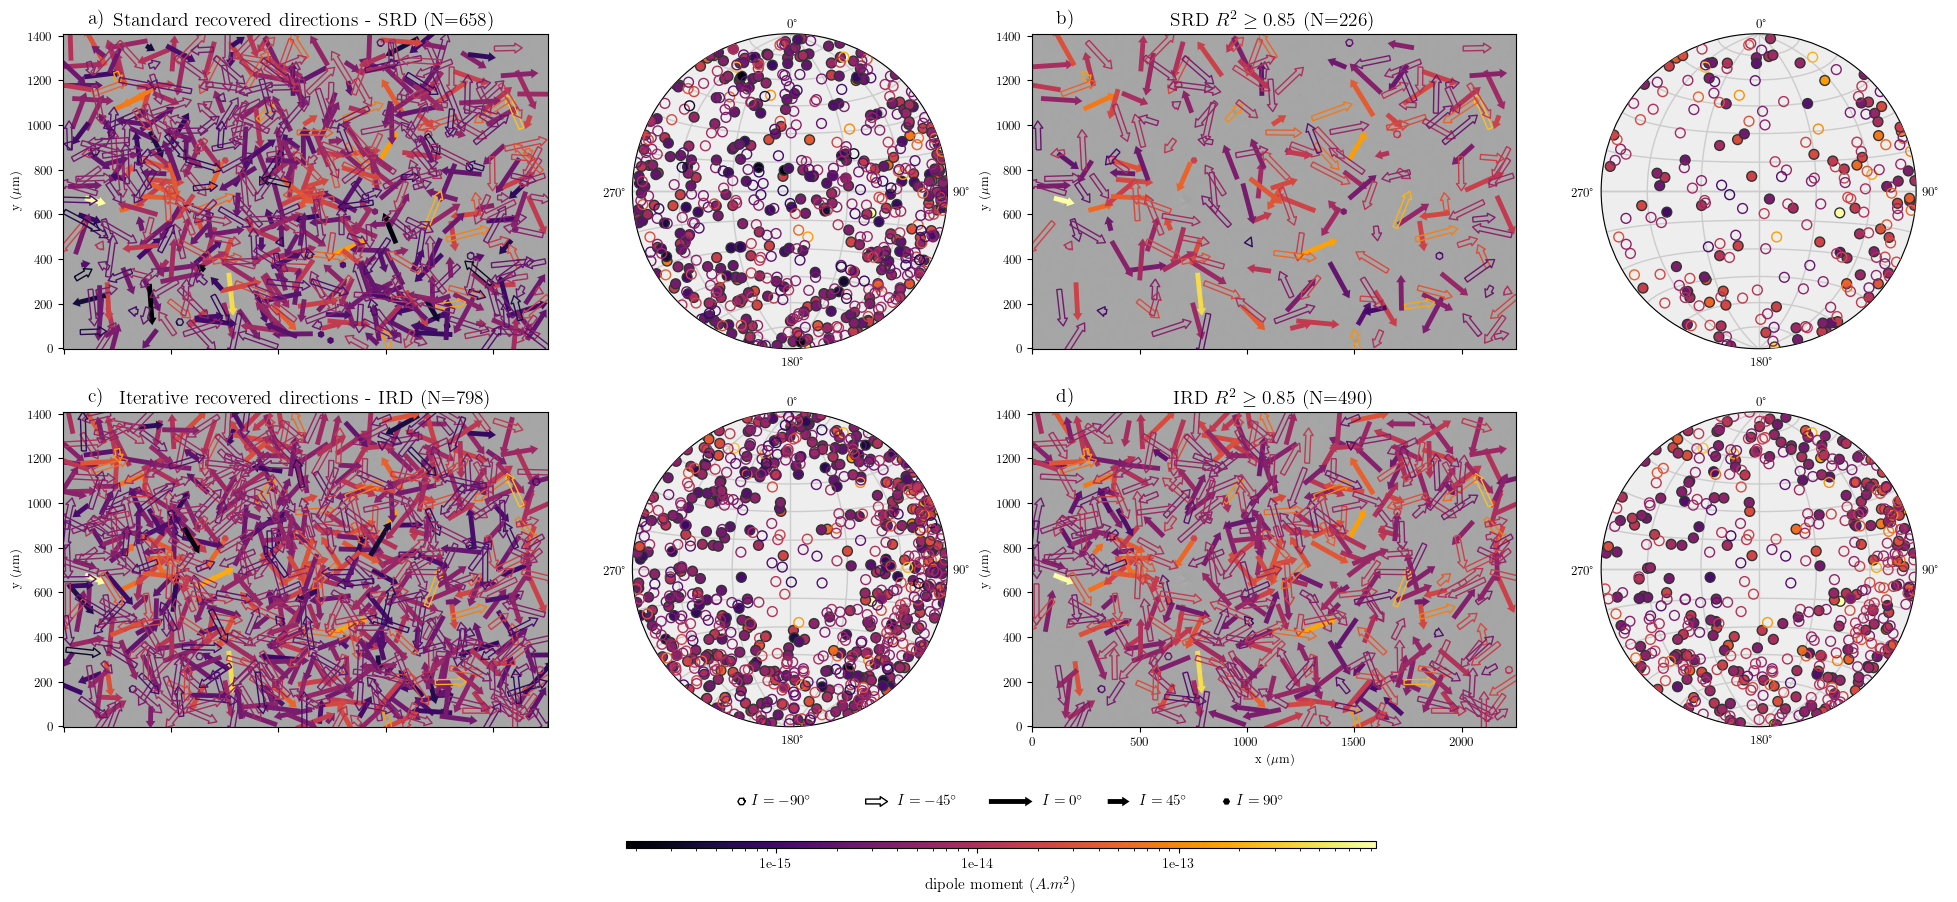

In [42]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

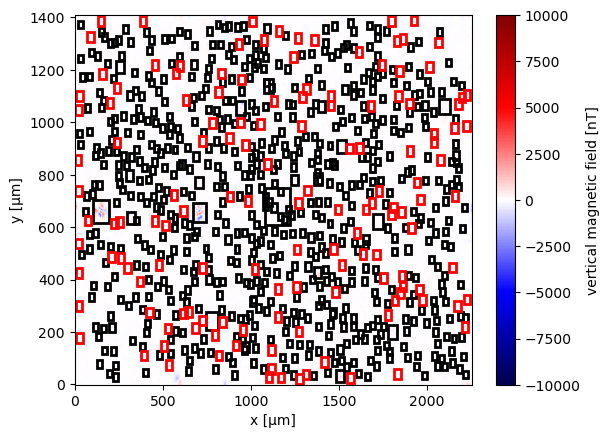

In [43]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [44]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.97808282,  0.58165651,  0.99735166,  0.95712529,  0.99766467,
        0.99487886,  0.99755989,  0.99905445,  0.99562989,  0.90490978,
        0.97656744,  0.99779233,  0.97829838,  0.99356093,  0.80879958,
        0.92845845,  0.99011055,  0.95547395,  0.95853254,  0.93234603,
        0.98866542,  0.99202406,  0.93893151,  0.98119771,  0.98408606,
        0.96823226,  0.9797975 ,  0.98623383,  0.99690288,  0.9787825 ,
        0.94198928,  0.99687397,  0.98269278,  0.95258377,  0.97850151,
        0.98328264,  0.99461969,  0.98605319,  0.9710762 ,  0.99104959,
        0.98772814,  0.97854813,  0.9291167 ,  0.95309759,  0.98049454,
        0.98339663,  0.9331033 ,  0.98901813,  0.99125526,  0.9984355 ,
        0.98442371,  0.29163287,  0.99304701,  0.99247522,  0.96191812,
        0.13923277,  0.9774288 ,  0.99157646,  0.97587036,  0.98109896,
        0.98771425,  0.95142565,  0.99796559,  0.89591157,  0.78181571,
        0.97869293,  0.97844918,  0.98691513,  0.99471613,  0.41

# Show the observed and predicted data

In [45]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

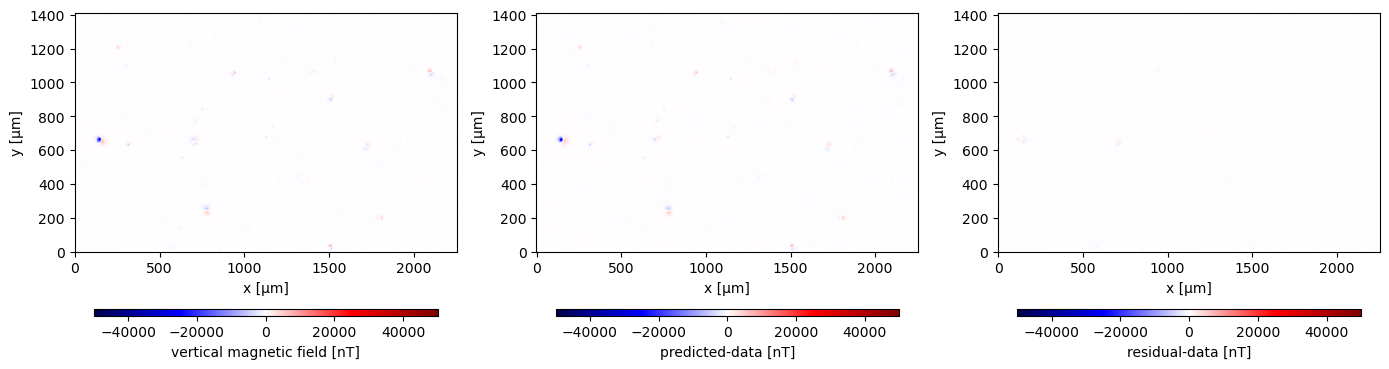

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +50000
    vmin = -50000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9780828176708977


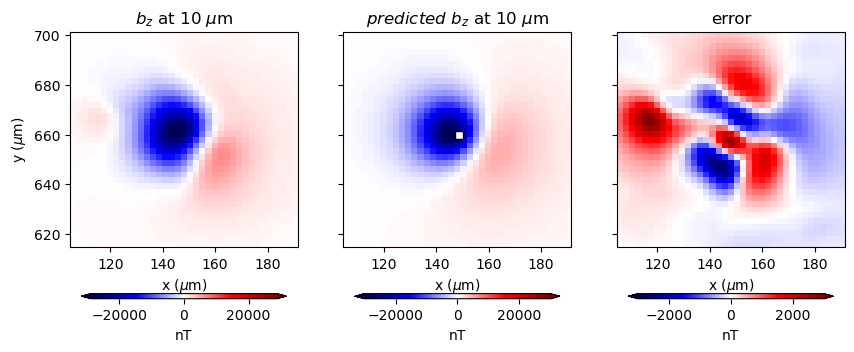

2
Individual source:   R2 = 0.5816565138350167


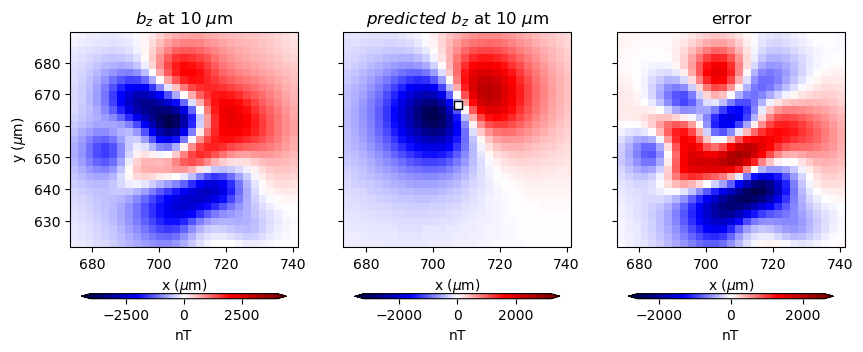

3
Individual source:   R2 = 0.9973516628359512


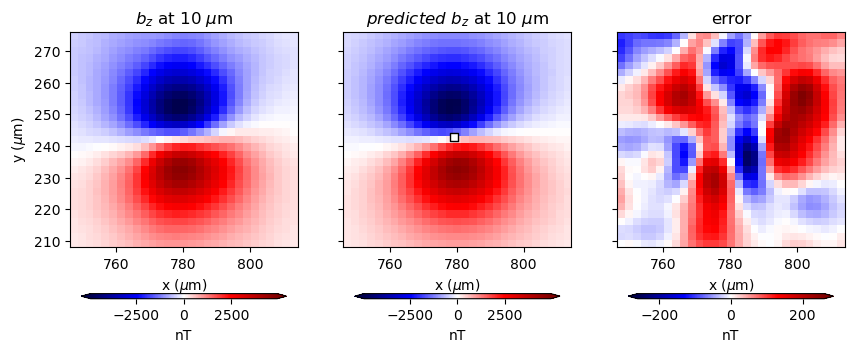

4
Individual source:   R2 = 0.9571252873090456


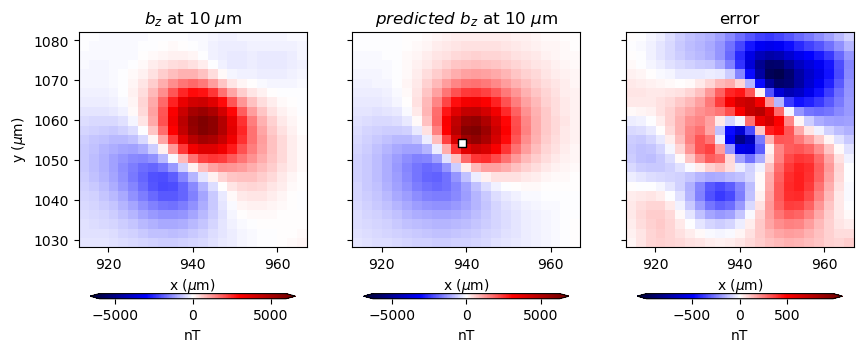

5
Individual source:   R2 = 0.9976646681560886


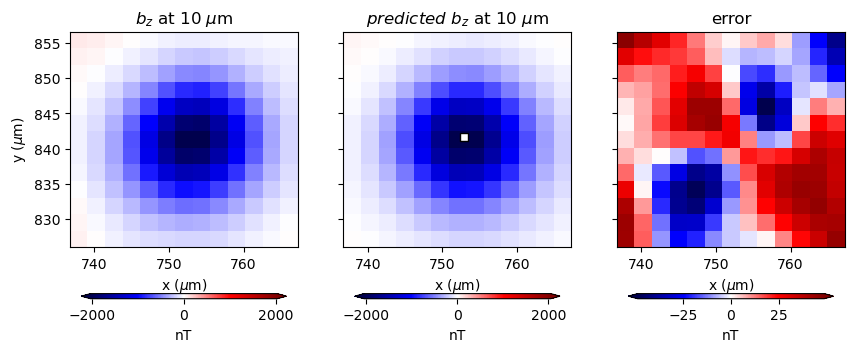

In [47]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [48]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [49]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows)[:, 0],
    'xmax': np.asarray(windows)[:, 1],
    'ymin': np.asarray(windows)[:, 2],
    'ymax': np.asarray(windows)[:, 3],
    'xc_standard': np.asarray(positions)[0, :],
    'yc_standard': np.asarray(positions)[1, :],
    'zc_standard': np.asarray(positions)[2, :],
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows_enhanced)[:, 0],
    'xmax': np.asarray(windows_enhanced)[:, 1],
    'ymin': np.asarray(windows_enhanced)[:, 2],
    'ymax': np.asarray(windows_enhanced)[:, 3],
    'xc_iterative': np.asarray(positions_itr_enhanced)[0, :],
    'yc_iterative': np.asarray(positions_itr_enhanced)[1, :],
    'zc_iterative': np.asarray(positions_itr_enhanced)[2, :],
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)